In [1]:
from animalai.envs.arena_config import Vector3, RGB, Item, Arena, ArenaConfig
from animalai.envs.environment import AnimalAIEnvironment
from mlagents_envs.exception import UnityCommunicationException

from typing import List
from animalai.communicator_objects import (
    ArenasConfigurationsProto,
    ArenaConfigurationProto,
    ItemToSpawnProto,
    VectorProto,
)

from typing import List
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import networkx as nx
from networkx import grid_graph

In [4]:
## We redefine the class ArenaConfig to MyArenaConfig so instead of reading a .yaml file.
## it reads the arena object we create

class MyArenaConfig(yaml.YAMLObject):
    yaml_tag = u"!ArenaConfig"

    def __init__(self, my_arena: Arena = None):

        self.arenas = {-1: my_arena}

    def to_proto(self, seed: int = -1) -> ArenasConfigurationsProto:
        arenas_configurations_proto = ArenasConfigurationsProto()
        arenas_configurations_proto.seed = seed

        for k in self.arenas:
            arenas_configurations_proto.arenas[k].CopyFrom(self.arenas[k].to_proto())

        return arenas_configurations_proto

In [3]:
## For simplicity, we only modify the position of the goal (position of agent is fixed)

def create_arena(x, y):
    '''
    Create an arena with only one agent and one goal.
    :param x: float. x position goal
    :param x: float. y position goal
    '''
    
    # Create agent
    position_agent = Vector3(x = 20, y = 0, z = 20)
    rotation_agent = 0
    agent = Item(name = 'Agent', positions = [position_agent], rotations = [rotation_agent])

    # Create the goal
    position_goal = Vector3(x = x, y = 0, z = y)
    sizes_goal = Vector3(x = 1, y = 1, z = 1)
    goal = Item(name = 'GoodGoal', positions = [position_goal], sizes = [sizes_goal])

    # Define list of items
    items = [agent, goal]

    # Create Arena
    my_arena = Arena(t=250, items=items, pass_mark = 0, blackouts = None)

    # create arena configuration
    my_config = MyArenaConfig(my_arena)
    
    return my_config

## 1. Generate matrix from arena

In [4]:
my_arena = create_arena(x=39, y=2)

In [5]:
def matrix_from_arena(my_arena):

    for k in my_arena.arenas:
        item_types = []
        item_types_value = []
        arena_m = np.zeros((40, 40)) - 1
        for (i, item) in enumerate(my_arena.arenas[k].items):
            # save each type of item
            item_types.append(item.name)
            item_types_value.append(i)
            # positions (in case one item takes more than one position)
            for (p, pos) in enumerate(item.positions):
                x = pos.x
                y = pos.z
                if item.sizes:
                    # if we have the size of the item
                    x_size = item.sizes[p].x
                    y_size = item.sizes[p].z

                    # where the item starts and ends
                    if x_size > 1:
                        start_x = x - int(x_size/2)
                        end_x = x + int(x_size/2)
                    else:
                        start_x = x
                        end_x = x
                    if y_size > 1:
                        start_y = y - int(y_size/2)
                        end_y = y + int(y_size/2)
                    else:
                        start_y = y
                        end_y = y

                    # paint figure
                    for x_ in range(start_x, end_x+1):
                        for y_ in range(start_y, end_y+1):
                            arena_m[x_, y_] = i
                else:
                    arena_m[x, y] = i

        fig = plt.imshow(arena_m, cmap=plt.get_cmap('Accent'))

        items = np.concatenate((['Arena'], item_types))

        # unique values
        values = np.unique(arena_m.ravel())
        # colormap used by imshow
        colors = [fig.cmap(fig.norm(value)) for value in values]
        # create a patch (proxy artist) for every color 
        patches = [mpatches.Patch(color=colors[i], label="{l}".format(l=items[i]) ) for i in range(len(values)) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

        plt.grid(False)
        plt.show()
        
        return arena_m

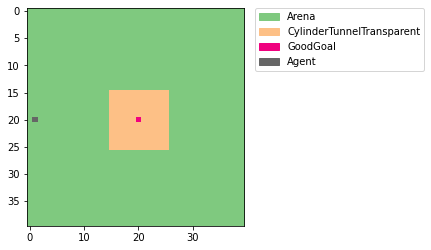

In [6]:
my_arena = ArenaConfig('configurations/arena_configurations/cylinder_task.yml')
arena_m = matrix_from_arena(my_arena)

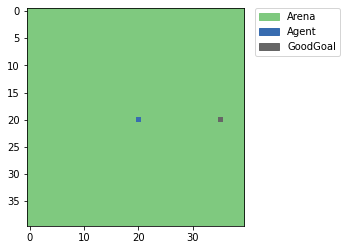

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [7]:
my_arena = ArenaConfig('configurations/curriculum/2.yml')
matrix_from_arena(my_arena)

## 2. Add item to an existing arena

In [8]:
def update_arena(old_arena, new_item):
    # we add the new item
    old_arena.items.append(new_item)

    # save the model in a arena and create new config
    new_arena = Arena(t=old_arena.t, items=old_arena.items, pass_mark = old_arena.pass_mark, blackouts = None)
    
    return new_arena

In [9]:
def create_wall(position = [2, 0, 20], size = [1, 1, 1]):
    '''
    Given the position and the size of the wall, it creates the item
    '''
    
    # create new item: wall
    position_wall = Vector3(x = position[0], y = position[1], z = position[2])
    sizes_wall = Vector3(x = size[0], y = size[1], z = size[2])
    
    return Item(name = 'Wall', positions = [position_wall], sizes = [sizes_wall])

Old Arena


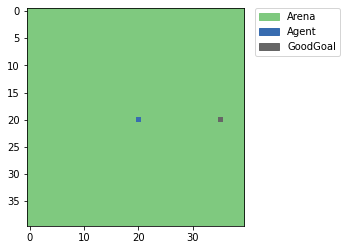

New Arena


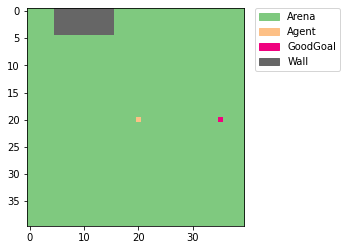

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [10]:
# Create Arena
my_arena = ArenaConfig('configurations/curriculum/2.yml')

print('Old Arena')
matrix_from_arena(my_arena)

# save old arena
old_arena = my_arena.arenas[-1]

# create wall
wall = create_wall(position = [2, 0, 10], size = [5, 1, 10])

# update
new_arena = update_arena(old_arena, new_item=wall)
new_arena = MyArenaConfig(new_arena)

print('New Arena')
matrix_from_arena(new_arena)

# 3.  Gym environment

In this section we create the gym environment as in PAIRED: https://github.com/google-research/google-research/blob/master/social_rl/gym_multigrid/envs/adversarial.py

In [5]:
import gym
from random import randint

In [6]:
class AdversarialEnv(gym.Env):
    ''' Grid world where an adversary build the environment the agent plays.
    The adversary places the goal, agent, and up to n_clutter blocks in sequence.
    The action dimension is the number of squares in the grid, and each action
    chooses where the next item should be placed. '''

    def __init__(self, n_clutter=10, size=40, goal_noise=0., random_z_dim=10, choose_goal_last=False):
        '''Initializes environment in which adversary places goal, agent, obstacles.
        Args:
          n_clutter: The maximum number of obstacles the adversary can place.
          size: The number of tiles across one side of the grid; i.e. make a size x size grid.
          max_steps: The maximum number of steps that can be taken before the episode terminates.
          goal_noise: The probability with which the goal will move to a different location than 
              the one chosen by the adversary.
          random_z_dim: The environment generates a random vector z to condition the adversary. 
              This gives the dimension of that vector.
          choose_goal_last: If True, will place the goal and agent as the last actions, rather than the first actions.
        '''
        # define params
        self.agent_start_pos = None
        self.goal_pos = None
        self.n_clutter = n_clutter
        self.goal_noise = goal_noise # we do not actualy use it (not yet)
        self.random_z_dim = random_z_dim
        self.choose_goal_last = choose_goal_last
        # Add two actions for placing the agent and goal.
        self.adversary_max_steps = self.n_clutter + 2
        self.width=size
        self.height=size
        
        self.reset_metrics()

        # Create spaces for adversary agent's specs: all spaces where it can place an object
        self.adversary_action_dim = size**2
        self.adversary_action_space = gym.spaces.Discrete(self.adversary_action_dim)
        self.adversary_ts_obs_space = gym.spaces.Box(
            low=0, high=self.adversary_max_steps, shape=(1,), dtype='uint8')
        self.adversary_randomz_obs_space = gym.spaces.Box(
            low=0, high=1.0, shape=(random_z_dim,), dtype=np.float32)
        # obs space: 0 if arena, 1 agent, 2 goal, walls 3
        self.adversary_image_obs_space = gym.spaces.Box(low=0,high=3,shape=(self.width, self.height, 1),dtype='uint8')

        # Adversary observations are dictionaries containing an encoding of the grid, the current time step, 
        # and a randomly generated vector used to condition generation (as in a GAN).
        self.adversary_observation_space = gym.spaces.Dict(
            {'image': self.adversary_image_obs_space,
             'time_step': self.adversary_ts_obs_space,
             'random_z': self.adversary_randomz_obs_space})

    def _gen_grid(self):
        """Grid is initially empty, because adversary will create it."""
        # Create an empty grid
        self.grid = np.zeros((self.width, self.height))
        
    def get_goal(self):
        if self.goal_pos is None:
            return -1
        return self.goal_pos[0]

    def get_agent(self):
        if self.goal_pos is None:
            return -1
        return self.agent_start_pos
    
    def reset_metrics(self):
        '''Define other metrics'''
        self.distance_to_goal = -1
        self.n_clutter_placed = 0
        self.deliberate_agent_placement = -1
        self.passable = -1
        self.adversary_step_count = 0
        self.graph = grid_graph(dim=[self.width, self.height])
        self.wall_locs = []
        
    def reset(self):
        '''Fully resets the environment to an empty grid with no agent or goal.'''
        
        self.adversary_step_count = 0

        self.agent_start_pos = None
        self.goal_pos = None

        # Extra metrics
        self.reset_metrics()

        # Generate the empty grid
        self._gen_grid()

        #image = self.grid.encode()
        obs = {
            'image': self.grid,
            'time_step': [self.adversary_step_count],
            'random_z': self.generate_random_z()
        }

        return obs
    
    def generate_random_z(self):
        return np.random.uniform(size=(self.random_z_dim,)).astype(np.float32)
    
    def remove_wall(self, x, y):
        # if there is a wall, remove it
        if self.grid[x, y] == 3:
            self.grid[x, y] = 0
            
    def render(self):
        fig = plt.imshow(self.grid, cmap=plt.get_cmap('Accent'))
        # values
        values = np.array([0, 1, 2, 3])
        #items
        items = ['Arena', 'Agent', 'Goal', 'Wall']
        # colormap used by imshow
        colors = [fig.cmap(fig.norm(value)) for value in values]
        # create a patch (proxy artist) for every color 
        patches = [mpatches.Patch(color=colors[i], label="{l}".format(l=items[i]) ) for i in range(len(values)) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

        plt.grid(False)
        plt.show()
        
    def compute_shortest_path(self):
        if self.agent_start_pos is None or self.goal_pos is None:
            return

        self.distance_to_goal = abs(
            self.goal_pos[0] - self.agent_start_pos[0]) + abs(
                self.goal_pos[1] - self.agent_start_pos[1])

        # Check if there is a path between agent start position and goal. Remember
        # to subtract 1 due to outside walls existing in the Grid, but not in the
        # networkx graph.
        self.passable = nx.has_path(
            self.graph,
            source=(self.agent_start_pos[0], self.agent_start_pos[1]),
            target=(self.goal_pos[0], self.goal_pos[1]))
        if self.passable:
          # Compute shortest path
            self.shortest_path_length = nx.shortest_path_length(
              self.graph,
              source=(self.agent_start_pos[0], self.agent_start_pos[1]),
              target=(self.goal_pos[0], self.goal_pos[1]))
        else:
          # Impassable environments have a shortest path length 1 longer than
          # longest possible path
            self.shortest_path_length = (self.width - 1) * (self.height - 1) + 1
    
    def step(self, loc):
    #def step(self, x, y):
        '''The adversary gets n_clutter + 2 moves to place the goal, agent, blocks.
        The action space is the number of possible squares in the grid. 
        The squares are numbered from left to right, top to bottom.
        Args:
          loc: An integer specifying the location to place the next object which
            must be decoded into x, y coordinates.
        Returns:
          Standard RL observation, reward (always 0), done, and info
        '''
        #if loc >= self.adversary_action_dim:
         #   raise ValueError('Position passed to step_adversary is outside the grid.')

        x = int(loc % self.width) 
        y = int(loc / self.width) 
        #done = False
        
        # Check if we should choose goal or agent
        if self.choose_goal_last:
            should_choose_goal = self.adversary_step_count == self.adversary_max_steps - 2
            should_choose_agent = self.adversary_step_count == self.adversary_max_steps - 1
        else:
            should_choose_goal = self.adversary_step_count == 0
            should_choose_agent = self.adversary_step_count == 1
        
        if should_choose_goal:
            self.grid[x, y] = 1
            self.goal_pos = [x, y]
        elif should_choose_agent:
            if self.grid[x, y] != 1:
                self.grid[x, y] = 2
                self.agent_start_pos = [x, y]
            else:
                while self.grid[x, y] == 1:
                    x = randint(1, 14)
                    y = randint(1, 14)
                    self.grid[x, y] = 2
                    self.agent_start_pos = [x, y]           
        else:
            if self.grid[x, y] != 1 and self.grid[x, y] != 2:
                self.grid[x, y] = 3
                if (x, y) not in self.wall_locs:
                    self.wall_locs.append((x, y))
            
        self.adversary_step_count += 1
            
        # End of episode
        if self.adversary_step_count >= self.adversary_max_steps:
            done = True
            
            # Build graph after we are certain agent and goal are placed
            for w in self.wall_locs:
                self.graph.remove_node(w)
            self.compute_shortest_path()

        obs = {
            'image': self.grid,
            'time_step': [self.adversary_step_count],
            'random_z': self.generate_random_z()
        }

        #return obs, env.shortest_path_length  if done else 0, done, {}
        return obs, 0, done, {}

In [8]:
env = AdversarialEnv()
env._gen_grid()
env.grid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
env.grid[2, 4] = 3
print(env.grid[env.grid == 3])
env.remove_wall(2, 4)
print(env.grid[env.grid == 3])

[3.]
[]


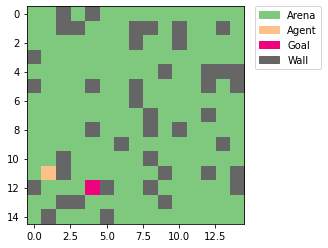

In [10]:
size = 15
n_blocks = 70
env = AdversarialEnv(n_clutter=n_blocks, random_z_dim=n_blocks, size=size)
env._gen_grid()
for i in range(50):
    #loc = randint(0, size**2-1)
    loc = env.adversary_action_space.sample()
    env.step(loc)
env.render()

In [20]:
env.compute_shortest_path()
env.shortest_path_length

16

## More simple

In [2]:
import gym
from gym.utils import seeding
import numpy as np

In [17]:
class AdversarialEnv(gym.Env):
    ''' Grid world where an adversary build the environment the agent plays.
    The adversary places the goal, agent, and up to n_clutter blocks in sequence.
    The action dimension is the number of squares in the grid, and each action
    chooses where the next item should be placed. '''

    def __init__(self, n_clutter=10, size=40, goal_noise=0., random_z_dim=10, choose_goal_last=False):
        '''Initializes environment in which adversary places goal, agent, obstacles.
        Args:
          n_clutter: The maximum number of obstacles the adversary can place.
          size: The number of tiles across one side of the grid; i.e. make a size x size grid.
          max_steps: The maximum number of steps that can be taken before the episode terminates.
        '''
        # define params
        self.agent_start_pos = None
        self.goal_pos = None
        self.n_clutter = n_clutter
        # Add two actions for placing the agent and goal.
        self.max_steps = self.n_clutter + 2
        self.size=size

        # Create spaces for adversary agent's specs: all spaces where it can place an object
        self.action_space = gym.spaces.Discrete(size**2)
        
        # lets start making the observation space easier
        self.observation_space = gym.spaces.Box(low=0,high=3,shape=(self.size, self.size),dtype='uint8')
        
        self.seed()
        
        self.reset()
        
    def reset(self):
        self.count = 0    
        self.state = np.zeros((self.size, self.size))
        self.reward = 0
        self.done = False
        self.info = {}
        
    def step (self, action):
        if self.done:
          # should never reach this point
            print("EPISODE DONE!!!")
        elif self.count == self.max_steps:
              self.done = True;
        else:
            try:
                assert self.action_space.contains(action)
                
                x = int(action % self.size) 
                y = int(action / self.size) 

                should_choose_goal = self.count == 0
                should_choose_agent = self.count == 1
                
                if should_choose_goal:
                    self.state[x, y] = 1
                    self.goal_pos = [x, y]
                elif should_choose_agent:
                    if self.state[x, y] != 1:
                        self.state[x, y] = 2
                    else:
                        while self.state[x, y] == 1:
                            l = self.action_space.sample()
                            x = int(action % self.size) 
                            y = int(action / self.size)
                        self.state[x, y] = 2
                    self.agent_start_pos = [x, y]    
                else:
                    if self.state[x, y] != 1 and self.state[x, y] != 2:
                        self.state[x, y] = 3
                        
                self.count += 1
                
            except AssertionError:
                print("INVALID ACTION", action)  
                
                
        try:
            assert self.observation_space.contains(self.state)
        except AssertionError:
            print("INVALID STATE", self.state)  
            
        
        return self.state, self.reward, self.done, self.info
    
    def render(self, mode="human"):
        s = "reward: {:2d}  info: {}"
        print(s.format(self.reward, self.info))
        
    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s)."""
        self.np_random, seed = seeding.np_random(seed)
        return [seed]